In [191]:
%matplotlib notebook

import itertools
import logging
from functools import partial
from collections import defaultdict, OrderedDict

import gensim
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib import colors as plt_colors
import numpy as np
import pandas as pnd
import os
from sklearn.cluster import *
from sklearn.preprocessing import normalize
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA, RandomizedPCA
from sklearn.manifold import TSNE
from sklearn import svm, metrics
from multiprocessing import Pool
from knub.thesis.util import *

pnd.set_option("display.max_colwidth", 200)
LIGHT_COLORS = ["#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6", "#ffff99"] # light colors
DARK_COLORS = ["#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a"] # dark colors

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
SIZE = 11
rc('font', size=SIZE)  # controls default text sizes
rc('axes', titlesize=SIZE)  # fontsize of the axes title
rc('axes', labelsize=SIZE)  # fontsize of the x and y labels
rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
rc('legend', fontsize=SIZE)  # legend fontsize
rc('figure', titlesize=SIZE)  # fontsize of the figure title
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [91]:
def evaluate_single(df_param):
    nr_inclusions = len(df_param)
    nr_succ = len(df_param[df_param.successful])
    return float(nr_succ) / nr_inclusions

def evaluate_df(df_param, print_eval):
    for method, df_group in df_param.groupby("method"):
        if "mixture" in method:
            continue
        succ_prob = evaluate_single(df_group)
        if print_eval:
            print "%s: %.2f" % (method, succ_prob)
    
def evaluate_file(f, print_eval=True):
    df_file = pnd.read_csv("/home/knub/Repositories/master-thesis/webapp/out/" + f, sep="\t", header=None)
    df_file.columns = ["inclusion_idx", "inclusion_id", "method", "words", "intruder", "selected_word", "successful"]
    evaluate_df(df_file, print_eval)
    return df_file

In [92]:
for f_name in sorted([f for f in os.listdir("../webapp/out") if f.endswith(".txt")]):
    print f_name
    evaluate_file(f_name)
    print

20_stefan.txt
20_lda: 0.65
20_lflda: 0.60
20_topicvec: 0.63
20_welda-gaussian: 0.80

20_tanja.txt
20_lda: 0.70
20_lflda: 0.40
20_topicvec: 0.47
20_welda-gaussian: 0.70

dominik.txt
lda: 0.68
lflda: 0.74
topicvec: 0.49
welda-gaussian: 0.82

dustin.txt
20_lda: 0.60
20_lflda: 0.45
20_topicvec: 0.63
20_welda-gaussian: 0.71
lda: 0.55
topicvec: 0.50
welda-gaussian: 0.61

joseph.txt
lda: 0.40
lflda: 0.68
topicvec: 0.69
welda-gaussian: 0.60

julian.txt
20_lda: 0.70
20_lflda: 0.45
20_topicvec: 0.74
20_welda-gaussian: 0.65
lflda: 0.44
topicvec: 0.61
welda-gaussian: 0.68

ralf.txt
20_lda: 0.70
20_lflda: 0.55
20_topicvec: 0.74
20_welda-gaussian: 0.55
lflda: 0.70
topicvec: 0.61
welda-gaussian: 0.68

stefan.txt
lda: 0.54
lflda: 0.72
topicvec: 0.65
welda-gaussian: 0.74

tanja.txt
lda: 0.48
lflda: 0.70
topicvec: 0.59
welda-gaussian: 0.66

toni.txt
20_lda: 0.58
20_lflda: 0.50
20_topicvec: 0.64
lda: 0.54
lflda: 0.58
topicvec: 0.54



**Evaluating all results**

In [100]:
dfs = []
for f_name in sorted([f for f in os.listdir("../webapp/out") if f.endswith(".txt")]):
    df_tmp = evaluate_file(f_name, print_eval=False)
    df_tmp["evaluator"] = f_name.replace(".txt", "").replace("20_", "")
    dfs.append(df_tmp)

df_all = pnd.concat(dfs)
        
evaluate_df(df_all, print_eval=True)

20_lda: 0.66
20_lflda: 0.49
20_topicvec: 0.64
20_welda-gaussian: 0.68
lda: 0.53
lflda: 0.66
topicvec: 0.59
welda-gaussian: 0.68


In [230]:
def aggregate_samples(df_param):
    return all(df_param)

df_agreement = df_all.groupby(["inclusion_id", "method"], as_index=False)["successful"].agg(aggregate_samples).reset_index()
pnd.reset_option('display.max_rows')
df_agreement.groupby("method")["successful"].agg(["mean", "count"])

,mean,count
method,,
20_lda,0.250000,20
20_lflda,0.100000,20
20_topicvec,0.368421,19
20_welda-gaussian,0.250000,20
20_welda-gaussian-mixture,0.400000,20
lda,0.220000,50
lflda,0.400000,100
topicvec,0.122449,49
welda-gaussian,0.260000,50


In [98]:
df_agreement.groupby(["method"])["mean"].mean()

method
20_lda                       0.657857
20_lflda                     0.485000
20_topicvec                  0.638596
20_welda-gaussian            0.681667
20_welda-gaussian-mixture    0.650000
lda                          0.538667
lflda                        0.675000
topicvec                     0.581787
welda-gaussian               0.682857
welda-gaussian-mixture       0.606667
Name: mean, dtype: float64

['20_lda', '20_lflda', '20_topicvec', '20_welda-gaussian']


<IPython.core.display.Javascript object>


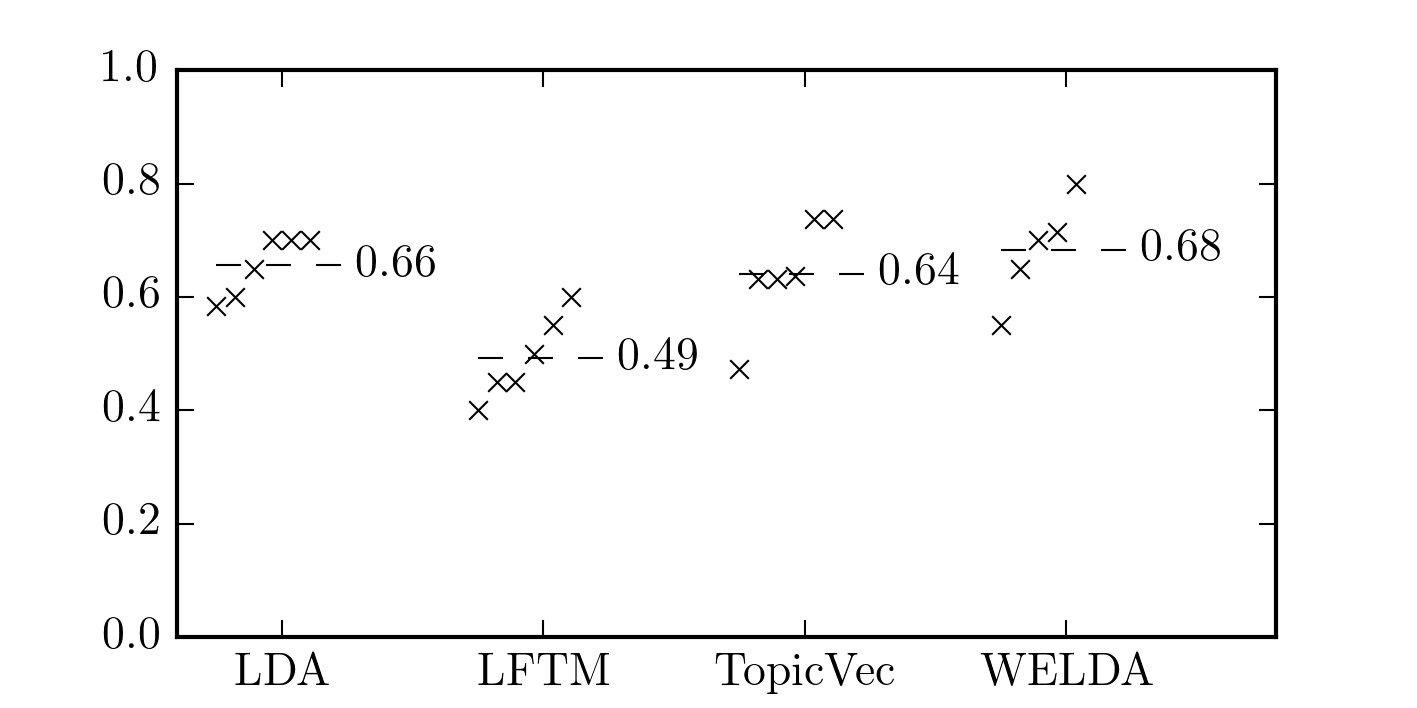

['lda', 'lflda', 'topicvec', 'welda-gaussian']


<IPython.core.display.Javascript object>


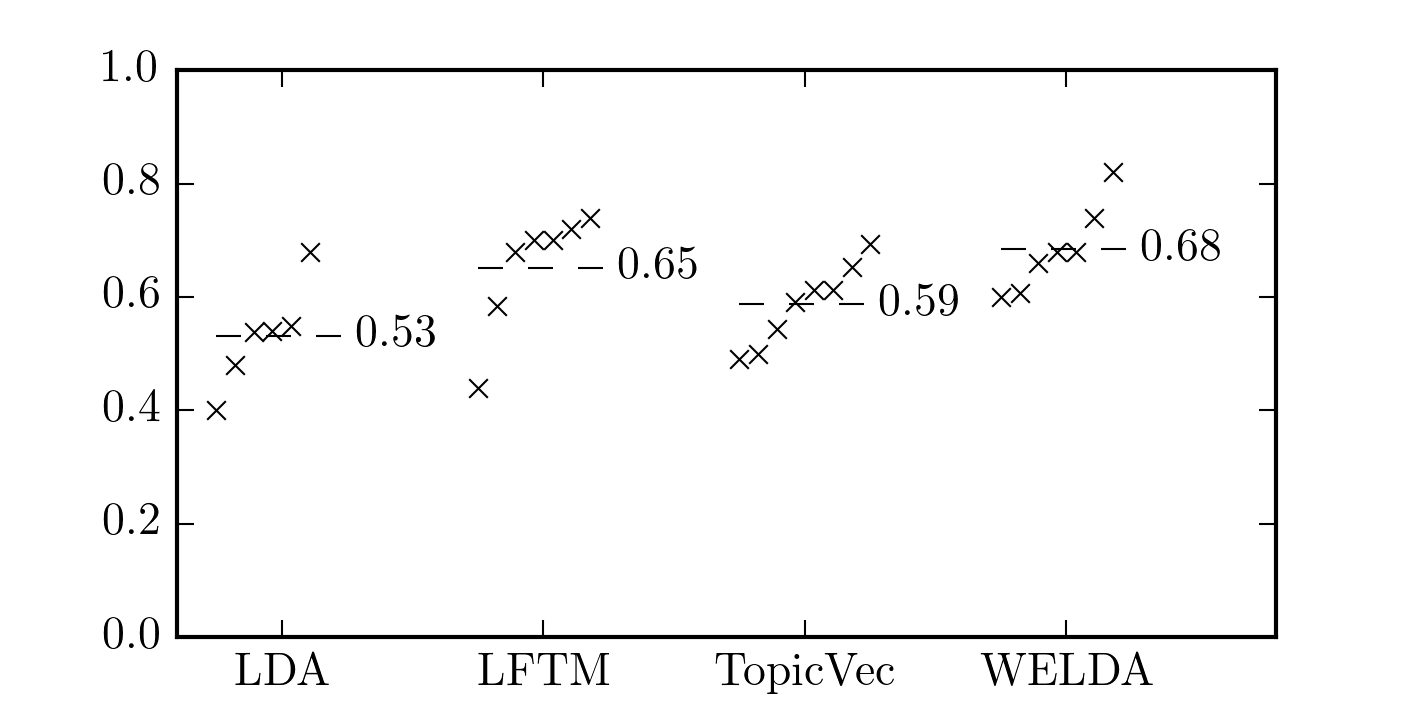

In [241]:
def build_word_intrusion(df_param):
    models = sorted(list(set(df_param.method)))
    evaluators = sorted(list(set(df_param.evaluator)))
    
    df_return = pnd.DataFrame(columns=models, index=evaluators)
    df_return.index.name = "evaluator"
    df_return.columns.name = "model"
    
    print models
    for evaluator, df_group_evaluator in df_param.groupby("evaluator"):
        for model, df_group_model in df_group_evaluator.groupby("method"):
            df_return.set_value(evaluator, model, evaluate_single(df_group_model))
    return df_return

def plot_word_intrusion(df_param):
    df_param = pnd.melt(df_param.reset_index(), id_vars=['evaluator'])
    df_param = df_param.dropna()
    df_param = df_param.sort_values(["model", "value"])
    models = sorted(list(set(df_param["model"])))
    for m in models:
        df_param.loc[df_param["model"] == m, "offset"] = range(len(df_param["model"] == m))
    models = OrderedDict([(v, k+1) for k, v in enumerate(models)])
    scatters = np.linspace(-0.25, 0.25, 8)
    
    df_param["scatter_x"] = df_param.apply(lambda x: models[x.model] + scatters[x.offset], axis=1)
    plt.figure(figsize=cm2inch(12, 6), dpi=300)
    plt.xlim(0.6, 4.8)
    plt.ylim((0.,1.0))
    plt.xticks(models.values(), ["LDA", "LFTM", "TopicVec", "WELDA"], rotation='horizontal')
    plt.scatter(df_param["scatter_x"], df_param["value"], c="black", marker='x', s=20, alpha=1.0, lw = 0.5)
    width = 0.25
    for m in models:
        mean = df_param[df_param.model == m]["value"].mean()
        #plt.axhline(y=mean)
        #print models[m]
        plt.hlines(y=mean, xmin=models[m]-width, xmax=models[m]+width, linestyles="dashed", linewidth=0.5)
        plt.text(models[m] + width + 0.03, mean, "$%.2f$" % mean, verticalalignment="center")

df_no_mixture = df_all[df_all.method.apply(lambda x: "mixture" not in x)]
df_20 = df_no_mixture[df_no_mixture.method.apply(lambda x: "20" in x)]
df_50 = df_no_mixture[df_no_mixture.method.apply(lambda x: "20" not in x)]

df_word_intrusion_20 = build_word_intrusion(df_20)
plot_word_intrusion(df_word_intrusion_20)

df_word_intrusion_50 = build_word_intrusion(df_50)
plot_word_intrusion(df_word_intrusion_50)

In [209]:
df_word_intrusion_20

model,20_lda,20_lflda,20_topicvec,20_welda-gaussian
evaluator,,,,
dustin,0.6,0.45,0.631579,0.714286
julian,0.7,0.45,0.736842,0.65
ralf,0.7,0.55,0.736842,0.55
stefan,0.65,0.6,0.631579,0.8
tanja,0.7,0.4,0.473684,0.7
toni,0.583333,0.5,0.636364,NaN


In [210]:
df_word_intrusion_50

model,lda,lflda,topicvec,welda-gaussian
evaluator,,,,
dominik,0.68,0.74,0.489796,0.82
dustin,0.54902,NaN,0.5,0.607843
joseph,0.4,0.68,0.693878,0.6
julian,NaN,0.44,0.612245,0.68
ralf,NaN,0.7,0.612245,0.68
stefan,0.54,0.72,0.653061,0.74
tanja,0.48,0.7,0.591837,0.66
toni,0.538462,0.583333,0.542857,NaN
